In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")


In [6]:
# Load Dataset
df = pd.read_csv("Loan Data.csv", delimiter=';')

# Clean column names
df.columns = df.columns.str.strip()

# Encode categorical variables
for col in ['AES', 'RES']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


In [7]:
# Feature Engineering
df['TotalDebt'] = df[['DMORT', 'DOUTM', 'DOUTL', 'DOUTHP', 'DOUTCC']].sum(axis=1)
df['DebtToIncome'] = df['TotalDebt'] / (df['DAINC'] + 1)
df['PhoneUsed'] = df['PHON'].astype(int)
df['Age'] = 2025 - df['YOB']

In [8]:
# Fill missing data
df.fillna(df.median(numeric_only=True), inplace=True)

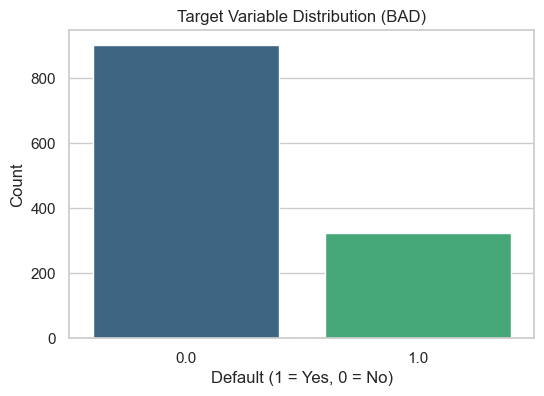

In [30]:
# VISUALIZATION: Class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='BAD', data=df, palette='viridis')
plt.title("Target Variable Distribution (BAD)")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

In [9]:

# Define Features & Target
features = [
    'NKID', 'DEP', 'SINC', 'AES', 'RES', 'DAINC', 'DHVAL', 'DMORT', 'DOUTM',
    'DOUTL', 'DOUTHP', 'DOUTCC', 'PhoneUsed', 'Age', 'TotalDebt', 'DebtToIncome'
]
X = df[features]
y = df['BAD'].astype(int)

In [10]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [11]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)


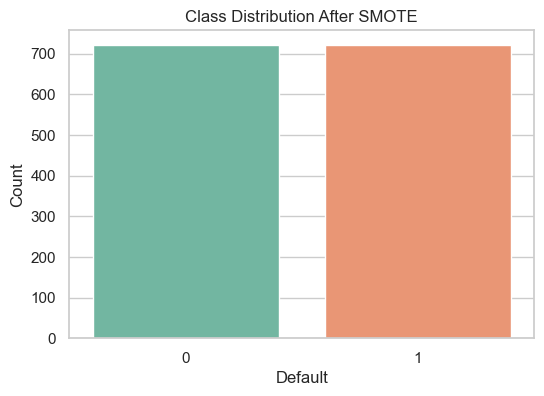

In [31]:
# VISUALIZATION: Resampled class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled, palette='Set2')
plt.title("Class Distribution After SMOTE")
plt.xlabel("Default")
plt.ylabel("Count")
plt.show()

In [13]:
# Class weight adjustment
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weight_dict = dict(zip(np.unique(y_resampled), class_weights))

In [14]:
# Models with Hyperparameter Tuning
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=3  # Adjust for class imbalance
)


In [16]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
}
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9]},
             scoring='f1', verbose=1)

In [17]:
# Best Model after GridSearch
best_xgb_model = grid_search.best_estimator_

# Train the optimized XGBoost model
best_xgb_model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
# Best Model after GridSearch
best_xgb_model = grid_search.best_estimator_

# Train the optimized XGBoost model
best_xgb_model.fit(X_resampled, y_resampled)

# Predict probabilities
y_proba = best_xgb_model.predict_proba(X_test_scaled)[:, 1]

In [19]:
# Find the best threshold for maximizing precision-recall balance
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"\n🔍 Best Threshold based on F1: {best_threshold:.2f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")



🔍 Best Threshold based on F1: 0.15
Precision: 0.3161, Recall: 0.8462, F1: 0.4603


In [20]:
# Final prediction with best threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Evaluation of Optimized Model
print("\n=== Final Evaluation on Test Set ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


=== Final Evaluation on Test Set ===
Confusion Matrix:
[[ 61 119]
 [ 10  55]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8592    0.3389    0.4861       180
           1     0.3161    0.8462    0.4603        65

    accuracy                         0.4735       245
   macro avg     0.5876    0.5925    0.4732       245
weighted avg     0.7151    0.4735    0.4792       245

ROC-AUC Score: 0.6209


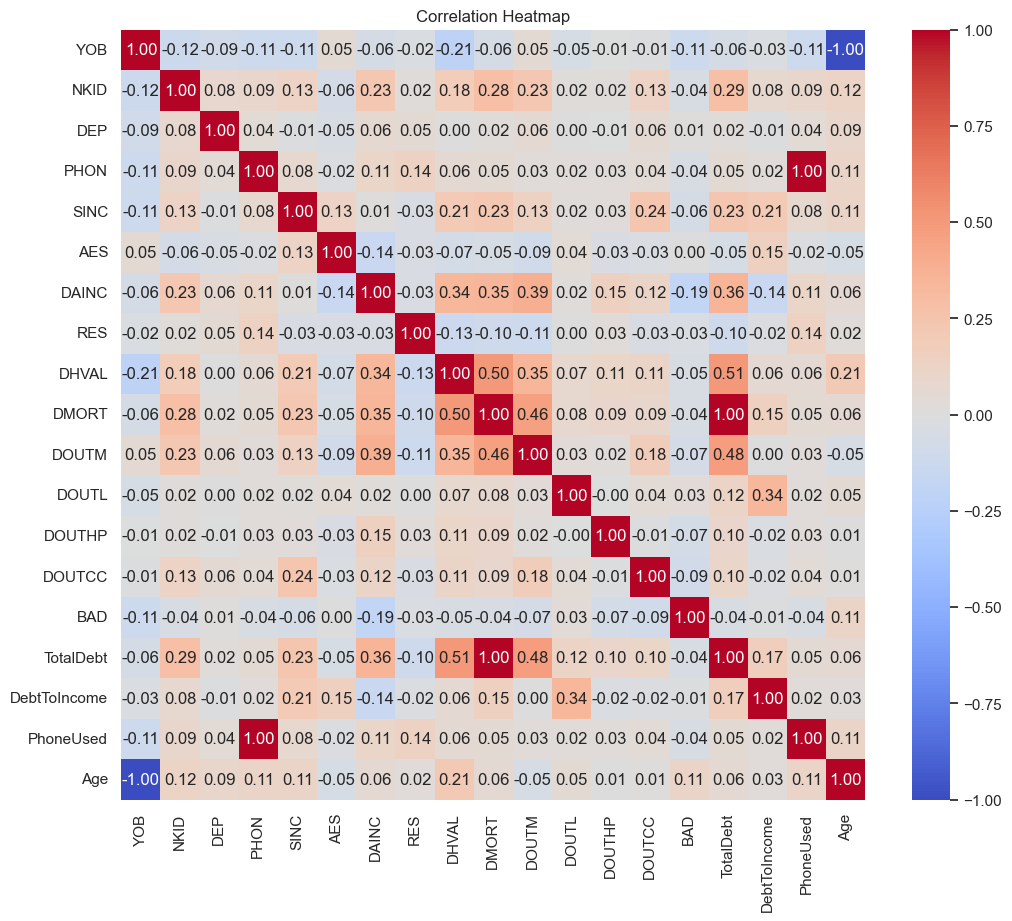

In [32]:
# VISUALIZATION: Correlation heatmap
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:

# Random Forest with Hyperparameter Tuning
rf_model = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=3, n_jobs=-1, verbose=1, scoring='f1')
rf_grid_search.fit(X_resampled, y_resampled)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight={0: 1.0, 1: 1.0},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [22]:
# Best Random Forest Model
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(X_resampled, y_resampled)
y_rf_pred = best_rf_model.predict(X_test_scaled)
y_rf_proba = best_rf_model.predict_proba(X_test_scaled)[:, 1]

In [23]:
# Gradient Boosting with Hyperparameter Tuning
gb_model = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.05, 0.1, 0.15],
}
gb_grid_search = GridSearchCV(gb_model, gb_param_grid, cv=3, n_jobs=-1, verbose=1, scoring='f1')
gb_grid_search.fit(X_resampled, y_resampled)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=1)

In [24]:
# Best Gradient Boosting Model
best_gb_model = gb_grid_search.best_estimator_
best_gb_model.fit(X_resampled, y_resampled)
y_gb_pred = best_gb_model.predict(X_test_scaled)
y_gb_proba = best_gb_model.predict_proba(X_test_scaled)[:, 1]


In [25]:
# Stacking / Voting Classifier for Ensemble
ensemble_model = VotingClassifier(estimators=[
    ('xgb', best_xgb_model),
    ('rf', best_rf_model),
    ('gb', best_gb_model)
], voting='soft')

ensemble_model.fit(X_resampled, y_resampled)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_con...
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(class_weight={0: 1.0,
                                                                   1: 1.0},
                                                     max_depth=5,
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('gb',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=5,
                                                         n_estimators=200,
                                                         random_state=42))],
                 voting='soft')

In [26]:
# Predict and evaluate ensemble model
y_ensemble_pred = ensemble_model.predict(X_test_scaled)
y_ensemble_proba = ensemble_model.predict_proba(X_test_scaled)[:, 1]

In [27]:
# Evaluation of Ensemble Model
print("\n=== Ensemble Model Evaluation ===")
print(confusion_matrix(y_test, y_ensemble_pred))
print(classification_report(y_test, y_ensemble_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_ensemble_proba):.4f}")


=== Ensemble Model Evaluation ===
[[146  34]
 [ 33  32]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       180
           1       0.48      0.49      0.49        65

    accuracy                           0.73       245
   macro avg       0.65      0.65      0.65       245
weighted avg       0.73      0.73      0.73       245

ROC-AUC Score: 0.6412


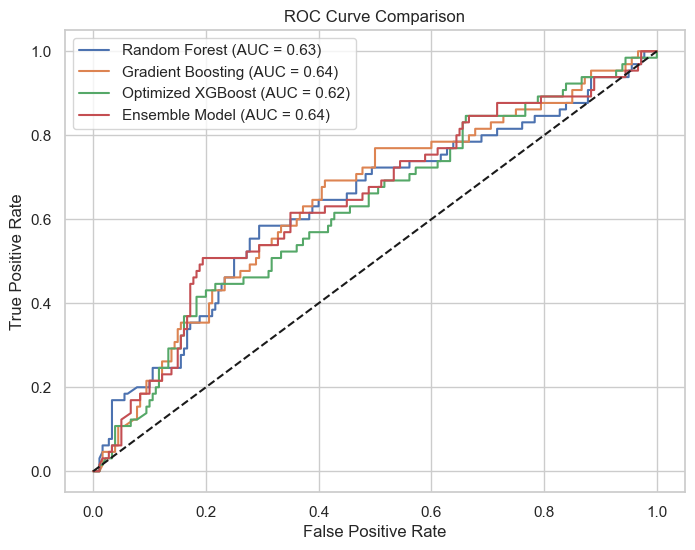

In [28]:
# VISUALIZATION: ROC Curves for All Models
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_rf_proba)
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, y_rf_proba):.2f})")
fpr, tpr, _ = roc_curve(y_test, y_gb_proba)
plt.plot(fpr, tpr, label=f"Gradient Boosting (AUC = {roc_auc_score(y_test, y_gb_proba):.2f})")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"Optimized XGBoost (AUC = {roc_auc_score(y_test, y_proba):.2f})")
fpr, tpr, _ = roc_curve(y_test, y_ensemble_proba)
plt.plot(fpr, tpr, label=f"Ensemble Model (AUC = {roc_auc_score(y_test, y_ensemble_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

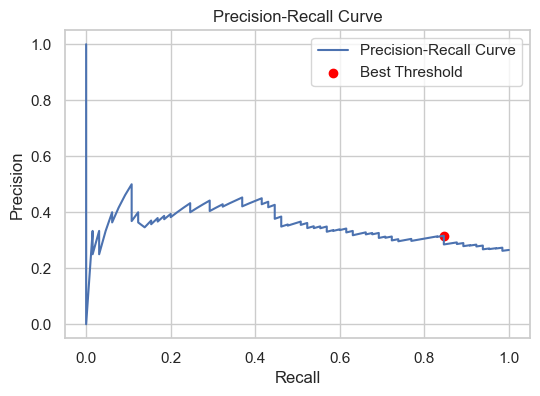

In [33]:
# Visualize PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.scatter(recall[best_idx], precision[best_idx], marker='o', color='red', label='Best Threshold')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

## 1. Dataset Preprocessing Steps:

### Data Loading and Cleaning:
The dataset is loaded using Pandas, and the column names are cleaned to remove leading and trailing spaces.

### Handling Categorical Variables:
The categorical variables, such as `AES` and `RES`, are encoded using `LabelEncoder` to convert them into numerical values, which is essential for model training.

### Feature Engineering:
Additional features like `TotalDebt`, `DebtToIncome`, and `PhoneUsed` are created to enhance the predictive power of the model. The `Age` feature is derived by subtracting the year of birth from the current year (2025).

### Handling Missing Values:
Missing values are filled with the median values of the respective columns using `df.median(numeric_only=True)`. This ensures that missing values don't interfere with model training.

---

## 2. Model Selection and Rationale:

### XGBoost:
XGBoost is chosen due to its efficiency and ability to handle large datasets and imbalances in the data. It also supports hyperparameter tuning, which is essential for optimizing model performance.

### Random Forest and Gradient Boosting:
These models are selected as additional baselines to compare the performance of XGBoost with other popular ensemble models.

### Ensemble Model:
A `Voting Classifier` is used to combine the predictions of the XGBoost, Random Forest, and Gradient Boosting models, leveraging the strengths of each individual model for improved performance.

---

## 3. Challenges Faced and Solutions:

### Class Imbalance:
The dataset had an imbalanced target variable (more "Non-Default" than "Default" cases). This was addressed using SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic instances of the minority class, which helps the model learn from the underrepresented class.

### Hyperparameter Tuning:
The performance of models like XGBoost, Random Forest, and Gradient Boosting was optimized using `GridSearchCV`, which tunes parameters such as `max_depth`, `n_estimators`, and `learning_rate`.

---

## 4. Results with Visualizations and Interpretations:

### Class Distribution Visualization:
Before resampling, the dataset had an imbalanced class distribution, with more cases of "Non-Default" than "Default".

### Resampled Class Distribution:
After SMOTE, the class distribution was balanced, providing the model with equal opportunities to learn from both classes.

### Correlation Heatmap:
This visualization helped identify correlations between features, allowing the model to understand relationships and dependencies within the data.

### Precision-Recall Curve:
This curve helps assess the performance of the model at various thresholds, emphasizing the trade-off between precision and recall. The best threshold was selected to maximize the F1 score.

### ROC Curve:
The ROC curve allows for evaluating how well the model distinguishes between the classes. The area under the curve (AUC) is used as a measure of model performance, where higher AUC indicates better performance.

---

## Conclusion:
The models, particularly the ensemble approach, showed promising results in predicting defaults (BAD) in the loan dataset. The use of SMOTE to balance the classes and the hyperparameter tuning process contributed significantly to the improvement in model performance.
